In [9]:
import os, glob
import numpy as np
import cv2
import random
import SimpleITK as sitk
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split

In [2]:
# Getting data name
path_data = os.path.join('/nas', 'breast')
path_abimg = os.path.join(path_data, 'image', 'abnormal')
path_nrimg = os.path.join(path_data, 'image', 'normal')

abnameList = sorted(glob.glob(os.path.join(path_abimg, '*.dcm')))
nrnameList = sorted(glob.glob(os.path.join(path_nrimg, '*.dcm')))

nameList = abnameList+nrnameList
labList = [1 if n < len(abnameList) else 0 for n in range(len(nameList))]

print(f'Abnormal: {len(abnameList)}')
print(f'Normal: {len(nrnameList)}')


Abnormal: 250
Normal: 250


In [4]:
# Train, validation, and test data
trainnameList, testnameList, trainlabList, testlabList= train_test_split(nameList, labList, test_size=0.1, random_state=4, stratify= labList)
trainnameList, validnameList, trainlabList, validlabList= train_test_split(trainnameList, trainlabList, test_size=0.1, random_state=4, stratify= trainlabList)

In [5]:
# Setting preprocessing data
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (18,18))

def getting_img(path_img, imageSize):
    img = sitk.ReadImage(path_img)
    img = sitk.GetArrayFromImage(img)[0]
    
    img = clahe.apply(img)
    img = img/(img.max()-img.min())

    img = cv2.resize(img, (imageSize, imageSize), interpolation=cv2.INTER_AREA)
    img = np.stack((img,)*3, axis=-1)
    
    return img

In [31]:
def img_generator(nameList, imageSize):
    # Iterate over all the image paths
    for name in nameList:

        img = getting_img(name, imageSize)
        if 'AN' in os.path.basename(name):
            lab = np.asarray([0, 1])
        else:
            lab = np.asarray([1, 0])
        
        yield img, lab

def img_batch_generator(nameList, imageSize, batchsize=10):
    while True:
        ig = img_generator(nameList, imageSize)
        batch_img, batch_lab = [], []
        
        for img, lab in ig:
            # Add the image and label to the batch
            batch_img.append(img)
            batch_lab.append(lab)
            
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_lab, axis=0)
                batch_img, batch_lab = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_lab, axis=0)
            batch_img, batch_lab = [], [] 

In [1]:
def Resnet50(inputs, n_class, weights='imagenet'):

    input_x = ResNet50(include_top=False, weights=weights, input_tensor=inputs)

    for layer in input_x.layers:
        layer.trainable=False

    x = input_x.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = BatchNormalization()(x)

    ## Fine tunning
    x = Dropout(0.2)(x)
    x = Dense(n_class, activation='softmax', name='output')(x)

   
    model = Model(inputs = inputs, outputs = x)
    
    return model

In [33]:
# Training classification model using Simple CNN model with data augmentation

path_save = os.path.join(os.path.abspath('.'), 'Result', 'model_pretrain')
os.makedirs(path_save, exist_ok=True)

## parameter setting
n_class = 2         
imageSize = 512     
lr = 0.0001
epochs = 50
batch = 10
loss_function = "categorical_crossentropy"

## model build
input_img = Input(shape=(imageSize,imageSize,3), name='input')

model = Resnet50(input_img, n_class)
# model.summary()                      # Check model structure

# Setting generator
train_gen = img_batch_generator(trainnameList, imageSize, batchsize=batch)
valid_gen = img_batch_generator(validnameList, imageSize, batchsize=batch)


## Callback
checkpointer = ModelCheckpoint(filepath=os.path.join(path_save,f'best_model.h5'), 
                                verbose=1, 
                                save_weights_only=True, 
                                save_best_only=True, 
                                monitor='val_loss', 
                                save_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0, min_delta=0.001, verbose=1)
callbacks_list = [reduce_lr, checkpointer]

## model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy"]
    )

## training model
model.fit(train_gen, 
            steps_per_epoch=len(trainnameList) // batch, 
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=len(validnameList)//batch,
            callbacks=callbacks_list
                        )

## saving last model weight
model.save_weights(os.path.join(path_save,f'last_model.h5'))

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.6075
Epoch 1: val_loss improved from inf to 1.79536, saving model to /home/user/workdir/my_data/Result/model_pretrain/best_model.h5
40/40 [==============================] - 83s 2s/step - loss: 0.6769 - accuracy: 0.6075 - val_loss: 1.7954 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6810
Epoch 2: val_loss improved from 1.79536 to 1.54739, saving model to /home/user/workdir/my_data/Result/model_pretrain/best_model.h5
40/40 [==============================] - 80s 2s/step - loss: 0.6032 - accuracy: 0.6810 - val_loss: 1.5474 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.7038
Epoch 3: val_loss improved from 1.54739 to 1.33097, saving model to /home/user/workdir/my_data/Result/model_pretrain/best_model.h5
40/40 [==============================

In [41]:
# Evaluation using test data
def change_channel(path_img):
    img = np.load(path_img)
    img = np.squeeze(img, axis=-1)
    img = np.stack((img,)*3, axis=-1)
    return img

test_x = change_channel(os.path.join(os.path.abspath('.'), 'npy', 'test_img.npy'))
print(test_x.shape)
test_y = np.load(os.path.join(os.path.abspath('.'), 'npy', 'test_lab.npy'))

_loss, _acc = model.evaluate(test_x, test_y, batch_size=10, verbose=1)
print('Last model accuracy')
print(f'loss: {_loss:0.3f} | accuracy: {_acc:0.3f}')

(50, 512, 512, 3)
5/5 [==============================] - 2s 147ms/step - loss: 0.3901 - accuracy: 0.8400
Last model accuracy
loss: 0.390 | accuracy: 0.840


In [42]:
## Using best model
model.load_weights(os.path.join(path_save,f'best_model.h5'))
_loss, _acc = model.evaluate(test_x, test_y, batch_size=10, verbose=1)
print('Best model accuracy')
print(f'loss: {_loss:0.3f} | accuracy: {_acc:0.3f}')

5/5 [==============================] - 1s 147ms/step - loss: 0.4012 - accuracy: 0.8400
Best model accuracy
loss: 0.401 | accuracy: 0.840


In [ ]:
# Checking fail data
test_result = model.predict(test_x, batch_size=10)

for a in range(len(test_result)):
    if test_result[a].argmax()!=test_y[a].argmax():
        plt.title(f'GT: {test_y[a].argmax()} | Result: {test_result[a].argmax()}')
        plt.imshow(test_x[a], cmap='gray')
        plt.show()

In [ ]:
def drawing_ROCcurve(test_y, test_result, path_save):
    from sklearn.metrics import roc_curve, auc
    n_classes = test_y.shape[-1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # First aggregate all false positive rates
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average (auc = {0:0.2f})".format(roc_auc["micro"]),
        color="maroon",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average (auc = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    
    for i, color in zip(range(n_classes), ['blue', 'yellow']):
        plt.plot(
            fpr[i],
            tpr[i],
            lw=lw,
            label="ROC curve (auc = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    plt.title("Receiver operating characteristic curves", fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.savefig(f'{path_save}/ROC_curve.png')


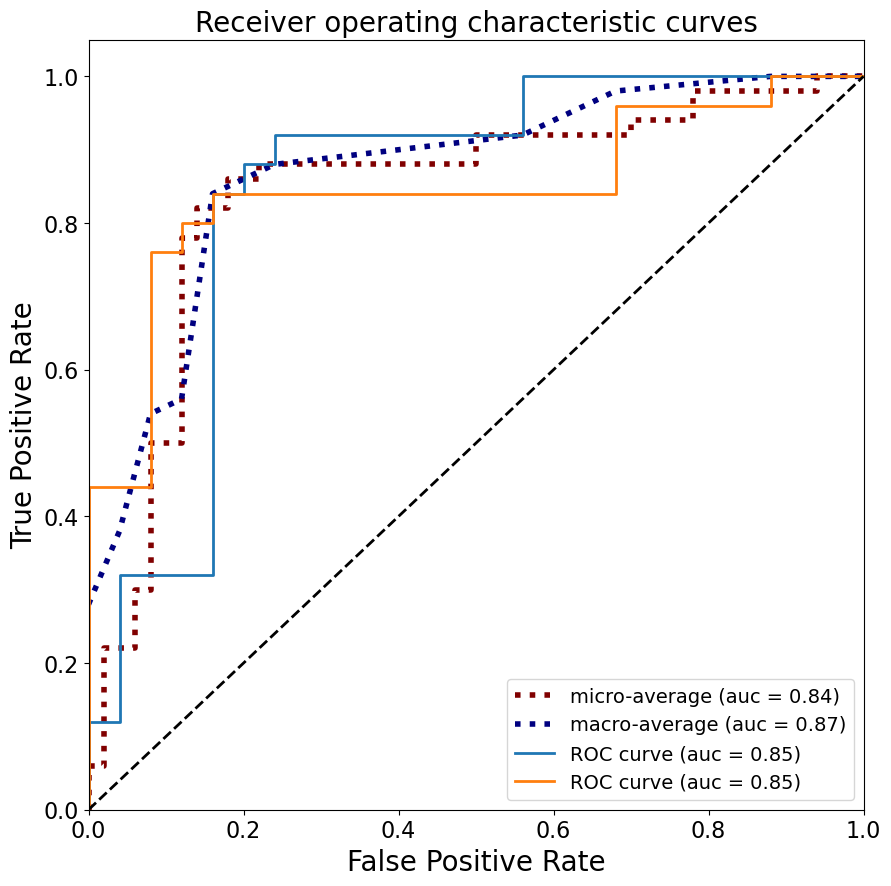

In [ ]:
drawing_ROCcurve(test_y, test_result, path_save)